### Homework 2: Uncertainty and Vision
CS-229 Spring 2023

The goal of this assignment is to get familiar with training a computer vision task (Segmentation) with PyTorch, and to measure confidence calibration in your system. 

In [1]:
%matplotlib inline
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.segmentation import fcn_resnet50

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# only needed for generating and storing results from grid search
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor

def get_voc_dataloader(batch_size=4, resize_shape=(256,256)):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # TODO: 2 points. 
    # Define image transforms for both the input image AND the "label" image.
    # Remember, the labels are one category (integer) per pixel. 
    # So, while the image_transform normalize the values to have mean zero and unit standard deviation, 
    # you shouldn't do that with the labels, which have to be integers. 

    # I provided a "ToIntTensor" transform above to use for the label transform, instead of ToTensor which always turns images to floats. 
    # Also, we want to resize/crop images to be all the same size, a power of 2, and 
    # we should transform the label and image in the same way when changing size.
    # The size of images will drastically impact memory usage - I suggest targeting 128 x 128 
    # or even 64 x 64 if memory constraints are an issue. 
    

    # error check for reshape size
    if type(resize_shape) is not tuple or len(resize_shape) != 2 or resize_shape[0] != resize_shape[1] or resize_shape[0] not in [2,4,8,16,32,64,128,256,512,1024]:
        raise Exception('Not valid reshape size')

    print ('Reshaping images to', resize_shape)

    # TODO
    image_transforms = transforms.Compose([
        transforms.Resize(resize_shape),
        transforms.ToTensor()
    ])    

    label_transforms = transforms.Compose([
        transforms.Resize(resize_shape),
        ToIntTensor()
    ])

    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    # TODO: Specify path to save data
    data_dir = "./"  
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)
    test_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='test', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl, test_dl
    
    

In [3]:
BATCH_SIZE = 4
train_dl_reshaped, val_dl_reshaped, test_dl_reshaped = get_voc_dataloader(BATCH_SIZE, (256,256))

Reshaping images to (256, 256)


100%|██████████| 460032000/460032000 [00:36<00:00, 12506503.13it/s]


Extracting ./VOCtrainval_06-Nov-2007.tar to ./
Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to ./


100%|██████████| 451020800/451020800 [00:35<00:00, 12549012.50it/s]


Extracting ./VOCtest_06-Nov-2007.tar to ./


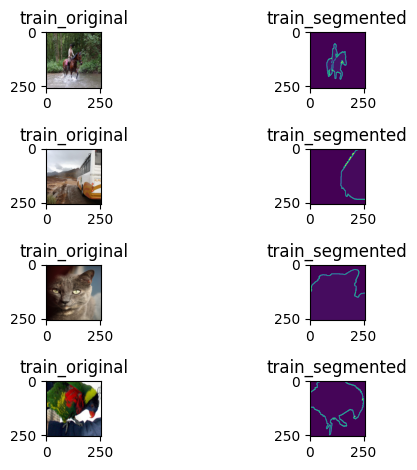

In [4]:
for _, (images,labels) in enumerate(train_dl_reshaped):
    fig, axs = plt.subplots(BATCH_SIZE, 2)

    for i in range(BATCH_SIZE):
        axs[i, 0].imshow(images[i].permute(1,2,0))
        axs[i, 0].set_title("train_original")

        axs[i, 1].imshow(labels[i].permute(1,2,0))
        axs[i, 1].set_title("train_segmented")

    fig.tight_layout()
    plt.show()
    break

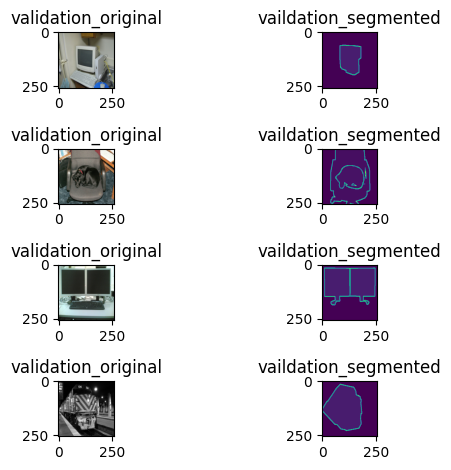

In [5]:
# plot a few validation samples
for _, (images,labels) in enumerate(val_dl_reshaped):
    fig, axs = plt.subplots(BATCH_SIZE, 2)

    for i in range(BATCH_SIZE):
        axs[i, 0].imshow(images[i].permute(1,2,0))
        axs[i, 0].set_title("validation_original")

        axs[i, 1].imshow(labels[i].permute(1,2,0))
        axs[i, 1].set_title("vaildation_segmented")

    fig.tight_layout()
    plt.show()
    break

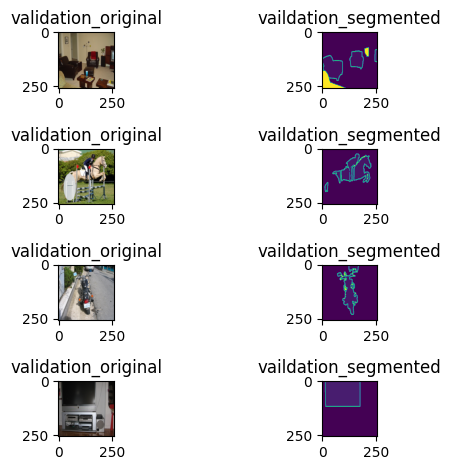

In [6]:
# plot a few validation samples
for _, (images,labels) in enumerate(train_dl_reshaped):
    fig, axs = plt.subplots(BATCH_SIZE, 2)

    for i in range(BATCH_SIZE):
        axs[i, 0].imshow(images[i].permute(1,2,0))
        axs[i, 0].set_title("validation_original")

        axs[i, 1].imshow(labels[i].permute(1,2,0))
        axs[i, 1].set_title("vaildation_segmented")

    fig.tight_layout()
    plt.show()
    break

In [7]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """

    # We'll use the cross entropy loss. There's a nice feature that it
    # allows you to "ignore_index". In this case index 255 is the mask to ignore
    # recommend to use in constructing loss
    criterion = nn.CrossEntropyLoss(ignore_index=255)  

    # TODO: Train (3 points)
    # Iterate over the train dataloader
    # Put data batch on same device as model
    # "Forward pass" - run data through model, and use output to calculate loss. 
    # "backward pass"
    # Remember to keep track of training loss during loop. 

    # Train Step
    model.train()
    train_loss = 0
    
    for _, (images,labels) in enumerate(train_dl):
        
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(1)
        
        # Forward pass
        output = model(images)['out']
        loss = criterion(output, labels)
    
        # Store loss
        with torch.no_grad():
            train_loss += loss.item()

        # Backward and optimize
        loss.backward()
        optimizer.step()
        
    # TODO: Validation loss and accuracy (2 points)
    # Estimate the loss on the validation dataset
    # The network should be in "eval" mode (remember to go back to train mode for training)
    # Turn off grad tracking for speed 
    # Accuracy on validation datais very helpful to output - 
    # 69(nice! :D) percent of pixels are "background" - we hope to get better accuracy than that!

    # Test Step
    model.eval()
    with torch.no_grad():

        val_loss = 0
        all_preds = []
        all_masks = []
        
        for  _, (images,labels) in enumerate(val_dl):
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(1)

            # Forward
            outputs = model(images)['out']
            loss = nn.CrossEntropyLoss(ignore_index=255)(outputs, labels)
            val_loss += loss.item()

            # Make prediction
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds)
            all_masks.append(labels)

        # Concatenate all preds from X,4,Y,Z to 4X,Y,Z
        all_preds = torch.concatenate(all_preds)
        all_masks = torch.concatenate(all_masks)

        # Reshape to get single vector instead of tensor 
        all_preds = all_preds.reshape(-1,1)
        all_masks = all_masks.reshape(-1,1)

        # calculate accuracy
        val_acc = torch.sum(all_preds == all_masks)/all_masks.shape[0]

    return train_loss, val_loss, val_acc.item()

        

### Main loop

In [8]:
def main_loop(batch_size=32, learning_rate=0.01, momentum=0.1, weight_decay=0.01, epochs=60, resize_shape=(256,256), early_stopping=False, patience=5):

    print ('----------------------------------------------------')
    print ('batch_size = {}, learning_rate = {}, momentum = {}, weight_decay = {}, epochs = {}, resize_shape = {}'.format(batch_size, learning_rate, momentum, weight_decay, epochs, resize_shape))

    # Load model and data
    n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored
    model = fcn_resnet50(n_class=n_class).to(device)
    train_dl, val_dl, _ = get_voc_dataloader(batch_size=batch_size, resize_shape=resize_shape)

    # Training loop
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    patience_ctr = 0
    best_acc = -1
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        train_loss, val_loss, val_accuracy = train_epoch(model, train_dl, val_dl, optimizer, device)
        
        # Print the loss, and store for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, val_accuracy))

        # early stopping
        if best_acc <= val_accuracy:
            patience_ctr = 0
            best_acc = val_accuracy
        else:
            patience_ctr += 1
            if patience_ctr >= patience and early_stopping == True:
                print ('Early Stopping as accuracy decreases')
                break




    plt.figure(1)
    plt.plot(torch.arange(len(train_losses)), train_losses, label='train_loss')
    plt.plot(torch.arange(len(val_losses)), val_losses, label='val_loss')
    plt.title('Train and Validation loss')
    plt.ylabel('loss')
    plt.xlabel('n_epochs')
    plt.grid()
    plt.legend()
    plt.show()

    plt.figure(1)
    plt.plot(torch.arange(len(val_accuracies)), val_accuracies, label='val_accuracy')
    plt.title('Validation Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('n_epochs')
    plt.grid()
    plt.legend()
    plt.show()

    return sum(train_losses)/len(train_losses), sum(val_losses)/len(val_losses), sum(val_accuracies)/len(val_accuracies), model, train_dl, val_dl

### Grid Search For hyper parameters

In [9]:
# # results from this will be linked below. do not run this, it will run for ~50 hrs

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps') if torch.backends.mps.is_available() else device

# # Search some optimal hyperparameters
# results = []
# # for epoch in [20, 40]:
# #     for learning_rate in [0.01, 0.001, 0.0001]:
# #         for batch_size in [16, 32, 64]:
# #             for resize_shape in [(128,128), (256,256)]:
# #                 for weight_decay in [0, 0.1, 0.01]:
# #                     for momentum in [0., 0.1, 0.5, 0.9, 1.]:

#                         if (batch_size == 64 and resize_shape == (256,256)):
#                           continue
                          
#                         train_loss, val_loss, val_acc, _, _, _ = main_loop(batch_size, learning_rate, weight_decay, momentum, epoch, resize_shape)

#                         results.append({
#                             'batch_size':batch_size,
#                             'learning_rate':learning_rate,
#                             'epoch':epoch,
#                             'resize_shape':resize_shape,
#                             'weight_decay':weight_decay,
#                             'momentum':momentum,
#                             'train_loss':train_loss,
#                             'val_loss':val_loss,
#                             'val_acc':val_acc,
#                         })

#                         df = pd.DataFrame.from_records(results)
#                         path_to_store = f'/content/drive/MyDrive/UCR/results_{iter}.csv'
#                         with open(path_to_store, 'w', encoding = 'utf-8-sig') as f:
#                             df.to_csv(f)

In [10]:
# The results from grid search are stored in the csv.
from urllib import request
request.urlretrieve('https://d1u36hdvoy9y69.cloudfront.net/cs-229-ml/results.csv','results.csv')

df = pd.read_csv('results.csv')
df = df.sort_values(by=['val_acc'], ascending=False)
df.head(10)

,epoch,learning_rate,batch_size,resize_shape,weight_decay,momentum,train_loss,val_loss,val_acc
125,40,0.01,16,"(256, 256)",0.10,0.0,4.660566,7.666572,0.803307
130,40,0.01,16,"(256, 256)",0.01,0.0,4.925307,7.856535,0.803028
160,40,0.01,32,"(256, 256)",0.01,0.0,2.540164,4.093119,0.802137
155,40,0.01,32,"(256, 256)",0.10,0.0,2.376173,3.996474,0.801836
150,40,0.01,32,"(256, 256)",0.00,0.0,2.531680,4.089894,0.799998
20,20,0.01,16,"(256, 256)",0.10,0.0,5.910290,8.202301,0.799369
131,40,0.01,16,"(256, 256)",0.01,0.1,6.041143,8.584558,0.798994
120,40,0.01,16,"(256, 256)",0.00,0.0,4.831833,7.916957,0.798457
156,40,0.01,32,"(256, 256)",0.10,0.1,2.741209,4.296331,0.797684
161,40,0.01,32,"(256, 256)",0.01,0.1,2.830769,4.313980,0.797613


### Main Loop Training with Optimal Hyperparameters

----------------------------------------------------
batch_size = 32, learning_rate = 0.01, momentum = 0.1, weight_decay = 0.01, epochs = 60, resize_shape = (256, 256)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


Reshaping images to (256, 256)
Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to ./
Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to ./
Using downloaded and verified file: ./VOCtest_06-Nov-2007.tar
Extracting ./VOCtest_06-Nov-2007.tar to ./
Epoch 1: Train loss: 14.236 | Val loss: 14.338 | Acc: 0.732
Epoch 2: Train loss: 6.677 | Val loss: 8.967 | Acc: 0.759
Epoch 3: Train loss: 5.207 | Val loss: 6.830 | Acc: 0.772
Epoch 4: Train loss: 4.318 | Val loss: 5.259 | Acc: 0.779
Epoch 5: Train loss: 3.964 | Val loss: 4.573 | Acc: 0.779
Epoch 6: Train loss: 3.453 | Val loss: 4.306 | Acc: 0.786
Epoch 7: Train loss: 3.157 | Val loss: 4.207 | Acc: 0.782
Epoch 8: Train loss: 2.899 | Val loss: 4.025 | Acc: 0.796
Epoch 9: Train loss: 2.707 | Val loss: 3.937 | Acc: 0.794
Epoch 10: Train loss: 2.569 | Val loss: 3.844 | Acc: 0.799
Epoch 11: Train loss: 2.454 | Val loss: 3.786 | Acc: 0.

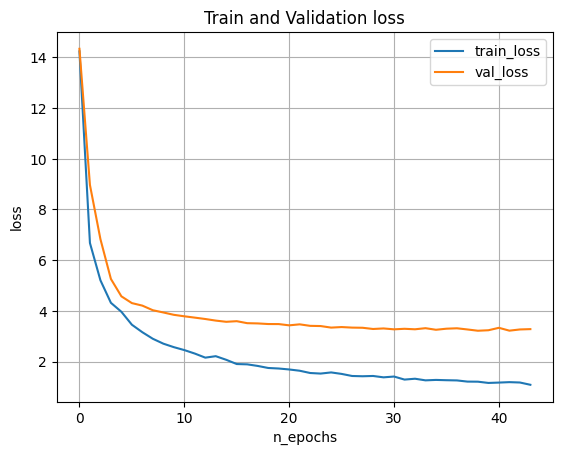

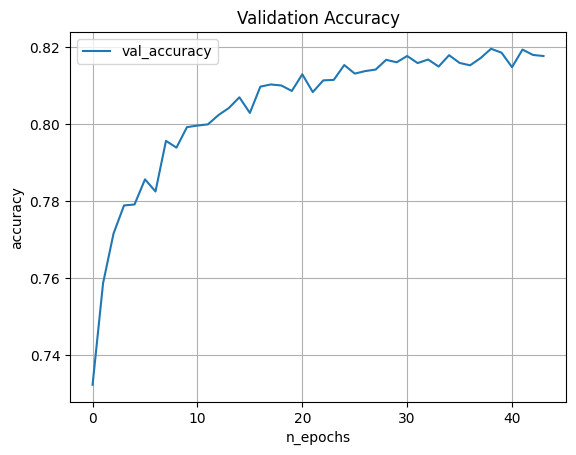

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
epochs = 60
learning_rate = 0.01
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored
batch_size = 32  # Adjust batch size to make maximal use of GPU without running out of memory 
resize_shape = (256,256)
weight_decay = 0.1
momentum = 0.01
early_stopping = True
patience = 5

train_loss, val_loss, val_acc, model, train_dl, val_dl = main_loop(batch_size, learning_rate, weight_decay, momentum, epochs, resize_shape, early_stopping, patience)

## Post training visualization and analysis

Reshaping images to (256, 256)
Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to ./
Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to ./
Using downloaded and verified file: ./VOCtest_06-Nov-2007.tar
Extracting ./VOCtest_06-Nov-2007.tar to ./


<ipython-input-12-aaa50a9cebda>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_class + 1)


<Figure size 4000x4000 with 0 Axes>

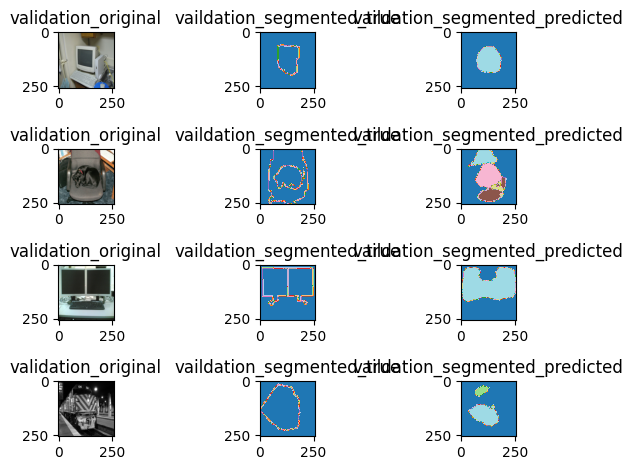

In [12]:
# TODO: Train and test loss plot
# TODO: Print out an example image, true segmentation, and predicted segmentation (1 point)
# Use a colormap to get good visualizations of the segmentation classes
# cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors
# cmap(numpy class array) outputs something with nice colors

train_dl, val_dl, test_dl = get_voc_dataloader(batch_size=5, resize_shape=(256,256))

# tab20 is a colormap with 20 distinct colors
cmap = plt.cm.get_cmap('tab20', n_class + 1)  
BATCH_SIZE_temp = 4
# plot a few validation samples
for _, (images,labels) in enumerate(val_dl):
    plt.figure(figsize=(40,40))
    fig, axs = plt.subplots(BATCH_SIZE_temp, 3)

    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      outputs = model(images)['out']
      preds = torch.argmax(outputs, dim=1)
      preds = preds.unsqueeze(1)

    for i in range(BATCH_SIZE_temp):
        axs[i, 0].imshow(torch.permute(images[i].to('cpu'), (1,2,0)))
        axs[i, 0].set_title("validation_original")

        axs[i, 1].imshow(torch.permute(labels[i].to('cpu'), (1,2,0)), cmap=cmap)
        axs[i, 1].set_title("vaildation_segmented_true")

        axs[i, 2].imshow(torch.permute(preds[i].to('cpu'), (1,2,0)), cmap=cmap)
        axs[i, 2].set_title("vaildation_segmented_predicted")

    fig.tight_layout()
    plt.show()
    break

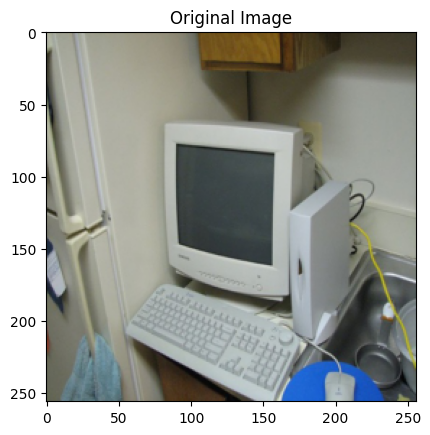

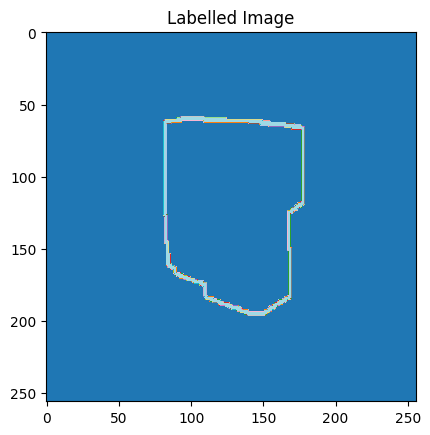

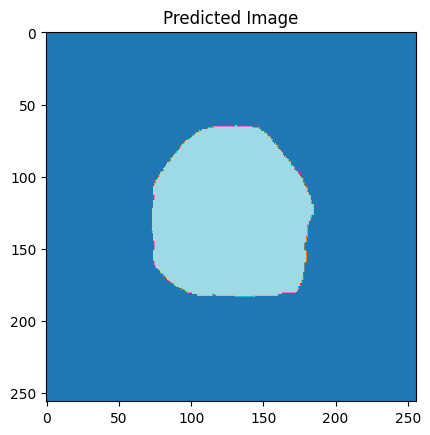

In [13]:
# Plot 1 set of images from validation set
first_batch = next(iter(val_dl))
images = first_batch[0].to(device)
labels = first_batch[1].to(device)

with torch.no_grad():
  outputs = model(images)['out']
  preds = torch.argmax(outputs, dim=1)
  preds = preds.unsqueeze(1)

plt.figure(1)
plt.title('Original Image')
plt.imshow(torch.permute(images[0].to('cpu'), (1,2,0)), cmap=cmap)
plt.show()
print ()

plt.figure(2)
plt.title('Labelled Image')
plt.imshow(torch.permute(labels[0].to('cpu'), (1,2,0)), cmap=cmap)
plt.show()
print ()

plt.figure(3)
plt.title('Predicted Image')
plt.imshow(torch.permute(preds[0].to('cpu'), (1,2,0)), cmap=cmap)
print ()

### Confidence Calibration for Validation Set

In [14]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):

        # move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # get predictions
        outputs = model(inputs)['out']
        
        # reshape y_true to column vector
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        
        # generate y_pred from model output and convert y_pred to column vector
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        
        # generate probabilities from outputs
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        
        # get max probability value for each pixel
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        
        # get accuracy
        accuracy = (predicted_label == labels)

        # get only samples that are less than mask
        accuracy_filter = accuracy[labels < 255]

        # get only samples that are less than mask
        confidence_filter = confidence[labels < 255]
        
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
# accuracy to predict pixel class across all pixels and images, excluding masks
all_acc = torch.cat(all_acc).cpu().numpy()  

# confidence of prediction for each pixel and image, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  
        

# Get the average confidence and accuracy for points within different confidence ranges
bins = 10

# Generate intervals from 0 to 1 inclusive at a step of 0.1
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)

bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin

# find how many points lie in which bins based on confidence value
# for each bin at index
for i in range(bins):
    # point lies in bin if the confidence in less than max of the bin and higher than the min of the bin
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])

    # find the fraction of points that lie in the bin
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  

    if bin_frac[i] > 0.:
        # average accuracy in this bin
        bin_acc[i] = all_acc[in_bin].mean()  
        # average confidence in this bin
        bin_conf[i] = all_conf[in_bin].mean()  
    else:
        # If no points are in this bin, they don't contribute to ECE anyway
        bin_acc[i], bin_conf[i] = 0, 0  

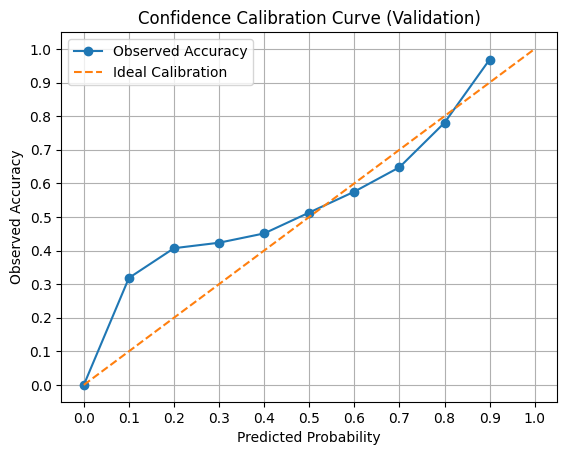

In [15]:
# TODO: Plot confidence calibration curve and calculate expected calibration error (1 point)

# plot the calibration curve
fig, ax = plt.subplots()
ax.plot(bin_lowers, bin_acc, marker='o', label='Observed Accuracy')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal Calibration')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Observed Accuracy')
ax.set_title('Confidence Calibration Curve (Validation)')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
ax.legend()

In [16]:
# Calculate ECE
ece = np.sum(np.abs(bin_acc - bin_lowers) * bin_frac)
print("ECE: ", ece)

ECE:  0.06005434410458268


Confidence Calibration for TEST Set

In [17]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(test_dl):

        # move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # get predictions
        outputs = model(inputs)['out']
        
        # reshape y_true to column vector
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        
        # generate y_pred from model output and convert y_pred to column vector
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        
        # generate probabilities from outputs
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        
        # get max probability value for each pixel
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        
        # get accuracy
        accuracy = (predicted_label == labels)

        # get only samples that are less than mask
        accuracy_filter = accuracy[labels < 255]

        # get only samples that are less than mask
        confidence_filter = confidence[labels < 255]
        
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
# accuracy to predict pixel class across all pixels and images, excluding masks
all_acc = torch.cat(all_acc).cpu().numpy()  

# confidence of prediction for each pixel and image, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  
        

# Get the average confidence and accuracy for points within different confidence ranges
bins = 10

# Generate intervals from 0 to 1 inclusive at a step of 0.1
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)

bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin

# find how many points lie in which bins based on confidence value
# for each bin at index
for i in range(bins):
    # point lies in bin if the confidence in less than max of the bin and higher than the min of the bin
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])

    # find the fraction of points that lie in the bin
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  

    if bin_frac[i] > 0.:
        # average accuracy in this bin
        bin_acc[i] = all_acc[in_bin].mean()  
        # average confidence in this bin
        bin_conf[i] = all_conf[in_bin].mean()  
    else:
        # If no points are in this bin, they don't contribute to ECE anyway
        bin_acc[i], bin_conf[i] = 0, 0  

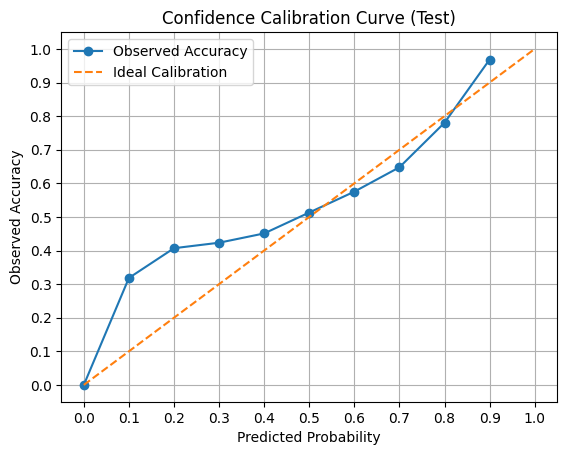

In [18]:
# TODO: Plot confidence calibration curve and calculate expected calibration error (1 point)

# plot the calibration curve
fig, ax = plt.subplots()
ax.plot(bin_lowers, bin_acc, marker='o', label='Observed Accuracy')
ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal Calibration')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Observed Accuracy')
ax.set_title('Confidence Calibration Curve (Test)')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
ax.legend()



In [19]:
# Calculate ECE
ece = np.sum(np.abs(bin_acc - bin_lowers) * bin_frac)
print("ECE: ", ece)

ECE:  0.06005434410458268


In [20]:
# !sudo apt-get update
# !sudo apt-get install texlive-xetex texlive-fonts-recommended
# !jupyter nbconvert --log-level CRITICAL --to pdf CS_229_Vision_uncertainty_HW_2.ipynb